In [1]:
import cftime
import glob
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from scipy import stats

import mission_tools

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
# Load the wave realization dataset
wave_df = pd.read_csv('../microSWIFT_data/wave_realizations_df.csv')
wave_df

,Unnamed: 0,time,mission number,height [m],cross shore location [m],along shore location [m]
0,0,2021-10-29 14:29:04.541608,78.0,1.634624,365.133427,549.829861
1,1,2021-10-29 14:29:11.374914,78.0,0.818419,364.549602,553.360727
2,2,2021-10-29 14:29:14.499902,78.0,0.395207,362.869111,554.889660
3,3,2021-10-29 14:29:17.749889,78.0,0.440129,363.308244,556.838904
4,4,2021-10-29 14:29:22.583203,78.0,1.093854,364.066896,558.825392
...,...,...,...,...,...,...
116524,116524,2021-10-22 14:47:02.991108,51.0,0.006356,97.951538,373.158218
116525,116525,2021-10-22 14:48:22.865788,51.0,0.004740,97.952482,373.160959
116526,116526,2021-10-22 14:49:40.865476,51.0,0.004470,98.011941,373.333641
116527,116527,2021-10-22 14:49:47.448784,51.0,0.003421,98.011941,373.333641


In [4]:
# Load the breaker dataset
breaker_df = pd.read_csv('../microSWIFT_data/breaker_df.csv')
breaker_df

,Unnamed: 0,time,mission number,cross shore location [m],cross shore location normalized [m],along shore location [m]
0,0,2021-10-29 14:32:02.457564,78.0,342.912569,0.644558,650.797664
1,1,2021-10-29 14:32:32.457444,78.0,309.671613,0.582076,671.188170
2,2,2021-10-29 14:34:57.456864,78.0,287.717313,0.540810,778.737823
3,3,2021-10-29 14:35:27.456744,78.0,223.654297,0.420393,799.877935
4,4,2021-10-29 14:35:47.456664,78.0,208.835801,0.392539,814.075185
...,...,...,...,...,...,...
3414,3414,2021-10-05 18:21:42.456243,4.0,188.567424,1.030392,80.595533
3415,3415,2021-10-05 18:13:12.458284,4.0,199.447297,1.089843,-61.277648
3416,3416,2021-10-14 13:00:27.458224,34.0,199.005140,0.855444,386.044583
3417,3417,2021-10-14 13:14:42.454804,34.0,205.019366,0.881297,480.649971


In [44]:
# Load the mission dataset
mission_df = pd.read_csv('../microSWIFT_data/mission_df.csv')
mission_df

,Unnamed: 0,time,mission number,Hs [m],Tm [s],Mean Dir [deg],cross shore gamma location [m],break depth
0,0,2021-10-29 14:33:54.998780,78,2.133724,8.298094,80.728183,532.012197,6.096354
1,1,2021-10-13 13:19:59.997600,29,1.092724,7.724980,58.598522,263.599684,3.122068
2,2,2021-10-07 14:34:59.998800,9,1.204854,6.205232,63.007655,283.712595,3.442439
3,3,2021-10-15 16:19:29.998200,39,0.588102,8.028343,80.680591,199.966839,1.680292
4,4,2021-10-28 15:41:59.998080,68,1.482833,9.009963,58.694913,378.892729,4.236665
...,...,...,...,...,...,...,...,...
62,62,2021-10-29 13:05:59.999280,75,2.160752,8.544953,80.367305,538.717394,6.173577
63,63,2021-10-11 13:21:29.997960,24,2.162277,7.025174,56.501510,539.095785,6.177935
64,64,2021-10-05 18:18:29.998680,4,0.522822,9.955173,84.789797,183.005448,1.493776
65,65,2021-10-14 13:07:29.998200,34,0.828214,8.194080,73.107152,232.633715,2.366327


In [75]:
# Organize the waves into Cross shore Distance Bins
mission_list = wave_df['mission number'].drop_duplicates()

# Define Cross Shore Bin Size
cross_shore_bin_size = 20

cross_shore_bin_centers_all = []
num_waves_in_bin_all = []
num_breakers_in_bin_all = []
breaking_fraction_all = []
hs_mission = []
tm_mission = []
mean_dir_mission = []

for mission_num in mission_list:
    # mission Specific Dataframes
    wave_df_mission = wave_df[wave_df['mission number'] == mission_num]
    breaker_df_mission = breaker_df[breaker_df['mission number'] == mission_num]
    mission_df_mission = mission_df[mission_df['mission number'] == mission_num]

    cross_shore_min = wave_df_mission['cross shore location [m]'].min()
    cross_shore_max = wave_df_mission['cross shore location [m]'].max()
    cross_shore_num_bins = int(np.floor((cross_shore_max - cross_shore_min)/ \
                                    cross_shore_bin_size))

    cross_shore_bin_edges = np.linspace(cross_shore_min, cross_shore_max,
                                        cross_shore_num_bins)

    cross_shore_bin_centers = (cross_shore_bin_edges[1:] + \
                           cross_shore_bin_edges[:-1]) / 2

    wave_heights_in_bins = []
    num_waves_in_bin = []
    for n in range(cross_shore_bin_centers.size):
        df = wave_df_mission[wave_df_mission['cross shore location [m]'].between(cross_shore_bin_edges[n], 
                                                                cross_shore_bin_edges[n+1])]
        wave_heights_in_bins.append(df['height [m]'])
        num_waves_in_bin.append(len(df.index))

    num_breakers_in_bin = []
    for n in range(cross_shore_bin_centers.size):
        df = breaker_df_mission[breaker_df_mission['cross shore location [m]'].between(cross_shore_bin_edges[n], 
                                                                cross_shore_bin_edges[n+1])]
        num_breakers_in_bin.append(len(df.index))

    cross_shore_bin_centers_all.append(cross_shore_bin_centers)
    num_waves_in_bin_all.append(num_waves_in_bin)
    num_breakers_in_bin_all.append(num_breakers_in_bin)

    # Compute breaking fraction
    breaking_fraction = np.array(num_breakers_in_bin)/np.array(num_waves_in_bin)
    breaking_fraction_all.append(breaking_fraction)

    # Add mission params
    hs_mission.append(mission_df_mission['Hs [m]'].iloc[0] * np.ones(breaking_fraction.size))
    tm_mission.append(mission_df_mission['Tm [s]'].iloc[0] * np.ones(breaking_fraction.size))
    mean_dir_mission.append(mission_df_mission['Mean Dir [deg]'].iloc[0] * np.ones(breaking_fraction.size))

cross_shore_bin_centers_all = np.concatenate(cross_shore_bin_centers_all)
breaking_fraction_all = np.concatenate(breaking_fraction_all)
hs_mission = np.concatenate(hs_mission)
tm_mission = np.concatenate(tm_mission)
mean_dir_mission = np.concatenate(mean_dir_mission)

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_32404/4276964811.py:51: RuntimeWarning: invalid value encountered in divide
  breaking_fraction = np.array(num_breakers_in_bin)/np.array(num_waves_in_bin)


Text(0, 0.5, 'Breaking Fraction, Qb [-]')

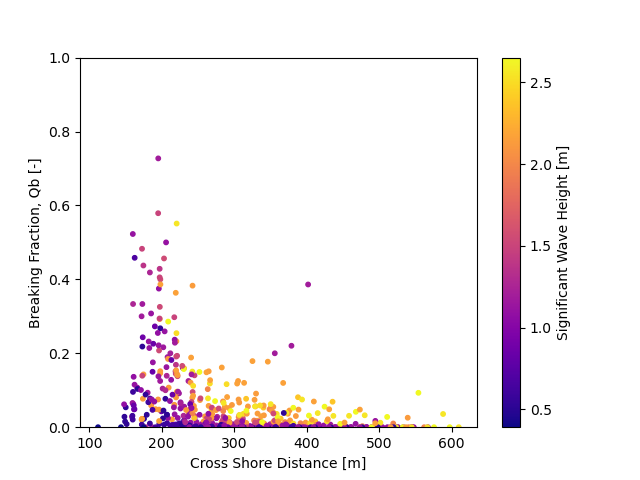

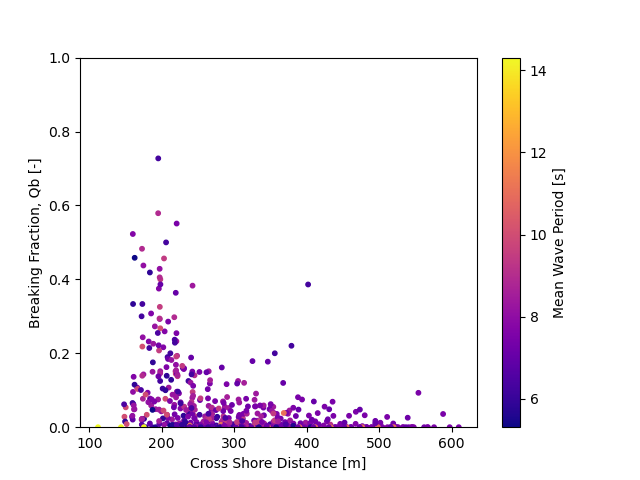

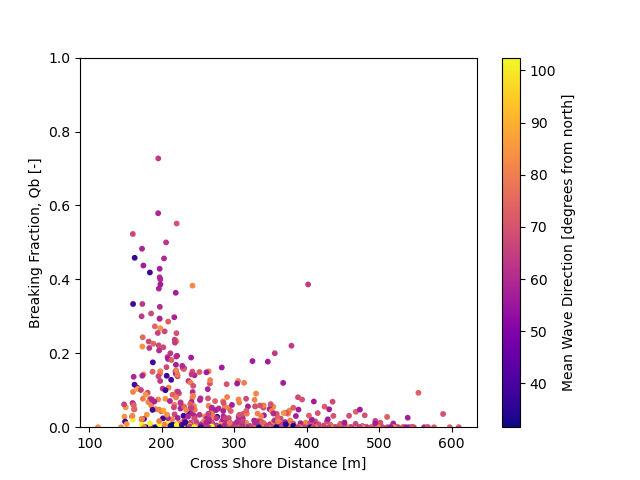

In [82]:
# Significant Wave Height
fig, ax = plt.subplots()
im = ax.scatter(cross_shore_bin_centers_all, breaking_fraction_all, s=10, c=hs_mission, cmap='plasma')
cbar = fig.colorbar(im)
cbar.set_label('Significant Wave Height [m]')
ax.set_ylim(0, 1)
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Breaking Fraction, Qb [-]')

# Mean Period
fig, ax = plt.subplots()
im = ax.scatter(cross_shore_bin_centers_all, breaking_fraction_all, s=10, c=tm_mission, cmap='plasma')
cbar = fig.colorbar(im)
cbar.set_label('Mean Wave Period [s]')
ax.set_ylim(0, 1)
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Breaking Fraction, Qb [-]')

# Mean Direction
fig, ax = plt.subplots()
im = ax.scatter(cross_shore_bin_centers_all, breaking_fraction_all, s=10, c=mean_dir_mission, cmap='plasma')
cbar = fig.colorbar(im)
cbar.set_label('Mean Wave Direction [degrees from north]')
ax.set_ylim(0, 1)
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Breaking Fraction, Qb [-]')